### 6. GBDT Model Training and Test

In [1]:
# import libraries used

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import  OneHotEncoder, LabelEncoder

import swifter
import gc

In [2]:
# Load processed dataset.

data = pd.read_pickle('v30_data_embed.pkl')

In [3]:
# train, validation, test data set parameter setting.

test_date_block = 34
val_date_block = test_date_block - 1
train_date_block = val_date_block - 1

In [4]:
high_loss_shops = [20, 9, 25, 31, 42, 28, 55]
#normal_shops = list(set(data.shop_id.unique()) - set(high_loss_shops))
normal_shops = list(set(data.shop_id.unique()))

#### 6.1 On Sale Model Training

#### 6.1.1 All Samples Model

In [5]:
on_sale_data = data.copy()

In [6]:
drop_list_on_sale = [
    'days',
    'shop_city',
    'avg_date_city_item_cnt_lag_1',
    'avg_date_city_item_cnt_lag_2',
    'avg_date_city_item_cnt_lag_3',
    'shop_item_on_market',
    #'shop_item_no_sale',
    #'avg_date_item_price_cnt_lag_1',
    'avg_date_item_price_cnt_lag_2',
    'avg_date_item_price_cnt_lag_3',
    #'avg_date_shop_item_price_cnt_lag_1',
    'avg_date_shop_item_price_cnt_lag_2',
    'avg_date_shop_item_price_cnt_lag_3',
    'avg_date_cat_price_cnt_lag_1',
    'avg_date_cat_price_cnt_lag_2',
    'avg_date_cat_price_cnt_lag_3',
    'avg_date_shop_cat_price_cnt_lag_1',
    'avg_date_shop_cat_price_cnt_lag_2',
    'avg_date_shop_cat_price_cnt_lag_3',
    'date_item_price_lag_2',
    'date_item_price_lag_3',
    'date_shop_item_price_lag_2',
    'date_shop_item_price_lag_3',
    #'date_shop_revenue_lag_1',
    'date_shop_revenue_lag_2',
    'date_shop_revenue_lag_3',
    #'date_shop_cat_revenue_lag_1',
    'date_shop_cat_revenue_lag_2',
    'date_shop_cat_revenue_lag_3',
]

on_sale_data.drop(drop_list_on_sale, axis=1, inplace=True)

In [7]:
#just extract the samples within the test dataset

'''
#just extract the samples within the test dataset
shop_list = list(on_sale_data[(on_sale_data.date_block_num == test_date_block) | \
                              (on_sale_data.date_block_num == val_date_block)].shop_id.unique())
item_list = list(on_sale_data[(on_sale_data.date_block_num == test_date_block) | \
                              (on_sale_data.date_block_num == val_date_block)].item_id.unique())

on_sale_data = on_sale_data[on_sale_data.shop_id.isin(shop_list)]
on_sale_data = on_sale_data[on_sale_data.item_id.isin(item_list)]

'''

'\n#just extract the samples within the test dataset\nshop_list = list(on_sale_data[(on_sale_data.date_block_num == test_date_block) |                               (on_sale_data.date_block_num == val_date_block)].shop_id.unique())\nitem_list = list(on_sale_data[(on_sale_data.date_block_num == test_date_block) |                               (on_sale_data.date_block_num == val_date_block)].item_id.unique())\n\non_sale_data = on_sale_data[on_sale_data.shop_id.isin(shop_list)]\non_sale_data = on_sale_data[on_sale_data.item_id.isin(item_list)]\n\n'

In [8]:
on_sale_data = on_sale_data[on_sale_data.time_on_market > 0]

In [9]:
X_train_on_sale = on_sale_data[(on_sale_data.date_block_num <= train_date_block) & \
                           on_sale_data.shop_id.isin(normal_shops)].drop(['date_shop_item_cnt'], axis=1)
Y_train_on_sale = on_sale_data[(on_sale_data.date_block_num <= train_date_block)& \
                           on_sale_data.shop_id.isin(normal_shops)]['date_shop_item_cnt']
X_valid_on_sale = on_sale_data[(on_sale_data.date_block_num == val_date_block) & \
                           on_sale_data.shop_id.isin(normal_shops)].drop(['date_shop_item_cnt'], axis=1)
Y_valid_on_sale = on_sale_data[(on_sale_data.date_block_num == val_date_block) & \
                           on_sale_data.shop_id.isin(normal_shops)]['date_shop_item_cnt']

In [10]:
X_train_on_sale_ft = X_train_on_sale.copy()
Y_train_on_sale_ft = Y_train_on_sale.copy()
X_valid_on_sale_ft = X_valid_on_sale.copy()
Y_valid_on_sale_ft = Y_valid_on_sale.copy()

In [11]:
embed_drop_list = [
    'date_block_num',
    'shop_id',
    'shop_type',
    'item_category_id', 
    'cat_type',
    'sub_type',
    'month',
]

X_train_on_sale_ft.drop(embed_drop_list, axis=1, inplace=True)
X_valid_on_sale_ft.drop(embed_drop_list, axis=1, inplace=True)

In [12]:
from xgboost import XGBRegressor
from xgboost import plot_importance


xgb_on_sale = XGBRegressor(
    max_depth=10,
    n_estimators=300,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.2, 
    reg_alpha=0.17,
    reg_lambda=0.171,
    seed=42)

xgb_on_sale.fit(
    X_train_on_sale_ft, 
    Y_train_on_sale_ft, 
    eval_metric="rmse", 
    eval_set=[(X_train_on_sale_ft, Y_train_on_sale_ft), (X_valid_on_sale_ft, Y_valid_on_sale_ft)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:1.01081	validation_1-rmse:0.95077
[1]	validation_0-rmse:0.92651	validation_1-rmse:0.88855
[2]	validation_0-rmse:0.86333	validation_1-rmse:0.84318
[3]	validation_0-rmse:0.82260	validation_1-rmse:0.81148
[4]	validation_0-rmse:0.79093	validation_1-rmse:0.79129
[5]	validation_0-rmse:0.76756	validation_1-rmse:0.77618
[6]	validation_0-rmse:0.75118	validation_1-rmse:0.76811
[7]	validation_0-rmse:0.73987	validation_1-rmse:0.76394
[8]	validation_0-rmse:0.73138	validation_1-rmse:0.75920
[9]	validation_0-rmse:0.72529	validation_1-rmse:0.75668
[10]	validation_0-rmse:0.72059	validation_1-rmse:0.75612
[11]	validation_0-rmse:0.71685	validation_1-rmse:0.75446
[12]	validation_0-rmse:0.71387	validation_1-rmse:0.75297
[13]	validation_0-rmse:0.71143	validation_1-rmse:0.75226
[14]	validation_0-rmse:0.70898	validation_1-rmse:0.75159
[15]	validation_0-rmse:0.70684	validation_1-rmse:0.75072
[16]	validation_0-rmse:0.70506	validation_1-rmse:0.75032
[17]	validation_0-rmse:0.70355	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=10,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.17, reg_lambda=0.171, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

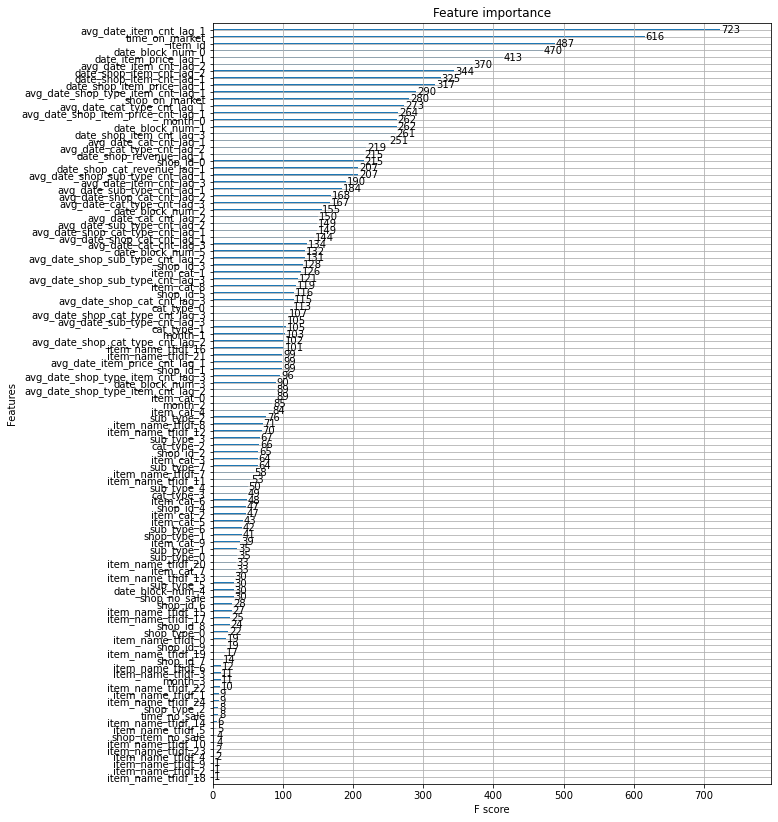

In [13]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(xgb_on_sale, (10,14))

#### 6.1.2 High Loss Shops

In [14]:
# prepare training dataset.

X_train_on_sale_hl = on_sale_data[(on_sale_data.date_block_num <= train_date_block)& \
                           on_sale_data.shop_id.isin(high_loss_shops)].drop(['date_shop_item_cnt'], axis=1)
Y_train_on_sale_hl = on_sale_data[(on_sale_data.date_block_num <= train_date_block)& \
                           on_sale_data.shop_id.isin(high_loss_shops)]['date_shop_item_cnt']
X_valid_on_sale_hl = on_sale_data[(on_sale_data.date_block_num == val_date_block)& \
                           on_sale_data.shop_id.isin(high_loss_shops)].drop(['date_shop_item_cnt'], axis=1)
Y_valid_on_sale_hl = on_sale_data[(on_sale_data.date_block_num == val_date_block)& \
                           on_sale_data.shop_id.isin(high_loss_shops)]['date_shop_item_cnt']

In [15]:
X_train_on_sale_hl_ft = X_train_on_sale_hl.copy()
Y_train_on_sale_hl_ft = Y_train_on_sale_hl.copy()
X_valid_on_sale_hl_ft = X_valid_on_sale_hl.copy()
Y_valid_on_sale_hl_ft = Y_valid_on_sale_hl.copy()

In [16]:
embed_drop_list = [
    'date_block_num',
    'shop_id',
    'shop_type',
    'item_category_id', 
    'cat_type',
    'sub_type',
    'month',
]

X_train_on_sale_hl_ft.drop(embed_drop_list, axis=1, inplace=True)
X_valid_on_sale_hl_ft.drop(embed_drop_list, axis=1, inplace=True)

In [17]:
from xgboost import XGBRegressor
from xgboost import plot_importance


xgb_on_sale_hl = XGBRegressor(
    max_depth=10,
    n_estimators=300,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.2, 
    reg_alpha=0.17,
    reg_lambda=0.171,
    seed=42)

xgb_on_sale_hl.fit(
    X_train_on_sale_hl_ft, 
    Y_train_on_sale_hl_ft, 
    eval_metric="rmse", 
    eval_set=[(X_train_on_sale_hl_ft, Y_train_on_sale_hl_ft), (X_valid_on_sale_hl_ft, Y_valid_on_sale_hl_ft)], 
    verbose=True, 
    early_stopping_rounds = 10)


[0]	validation_0-rmse:1.64613	validation_1-rmse:1.70792
[1]	validation_0-rmse:1.50351	validation_1-rmse:1.62525
[2]	validation_0-rmse:1.40097	validation_1-rmse:1.55901
[3]	validation_0-rmse:1.32744	validation_1-rmse:1.52349
[4]	validation_0-rmse:1.27619	validation_1-rmse:1.49479
[5]	validation_0-rmse:1.23920	validation_1-rmse:1.47860
[6]	validation_0-rmse:1.21192	validation_1-rmse:1.46534
[7]	validation_0-rmse:1.19184	validation_1-rmse:1.45891
[8]	validation_0-rmse:1.17675	validation_1-rmse:1.45078
[9]	validation_0-rmse:1.16497	validation_1-rmse:1.44763
[10]	validation_0-rmse:1.15644	validation_1-rmse:1.44358
[11]	validation_0-rmse:1.14976	validation_1-rmse:1.44114
[12]	validation_0-rmse:1.14494	validation_1-rmse:1.44339
[13]	validation_0-rmse:1.13975	validation_1-rmse:1.43895
[14]	validation_0-rmse:1.13613	validation_1-rmse:1.43760
[15]	validation_0-rmse:1.13240	validation_1-rmse:1.43576
[16]	validation_0-rmse:1.12961	validation_1-rmse:1.43479
[17]	validation_0-rmse:1.12754	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=10,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.17, reg_lambda=0.171, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

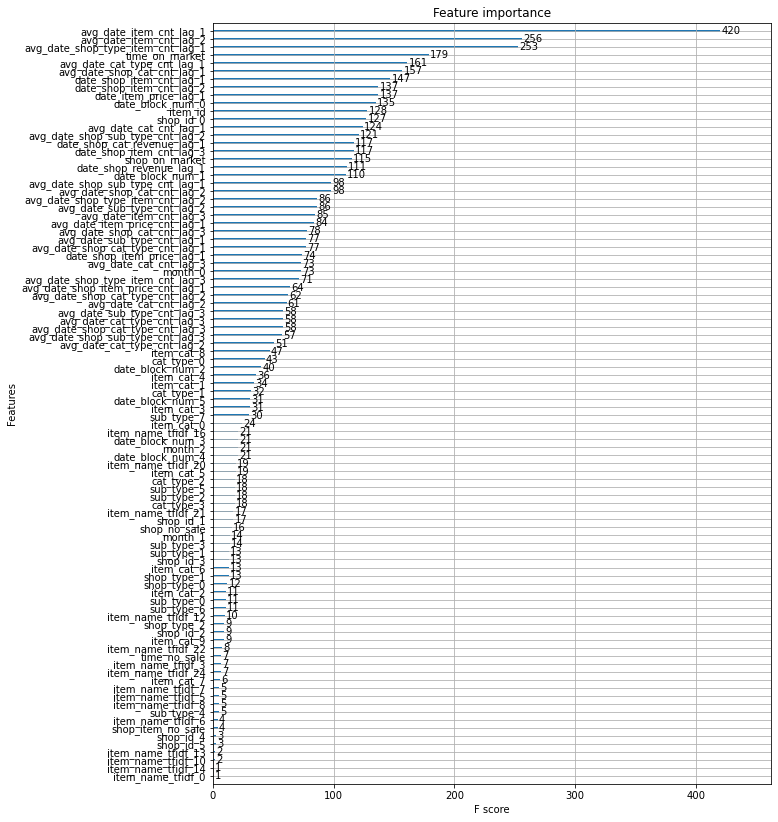

In [18]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(xgb_on_sale_hl, (10,14))

#### 6.2 First Sale Model Training

#### 6.2.1 All Samples

In [19]:
first_sale_data = data.copy()

In [20]:
drop_list_first_sale = [
    'days',
    'shop_city',
    'avg_date_city_item_cnt_lag_1',
    'avg_date_city_item_cnt_lag_2',
    'avg_date_city_item_cnt_lag_3',
    #'time_on_market',
    #'time_no_sale',
    'shop_item_on_market',
    #'shop_item_no_sale',
    'date_shop_item_cnt_lag_1',
    'date_shop_item_cnt_lag_2',
    'date_shop_item_cnt_lag_3',
    'avg_date_item_cnt_lag_1',
    'avg_date_item_cnt_lag_2',
    'avg_date_item_cnt_lag_3',
    'avg_date_shop_type_item_cnt_lag_1',
    'avg_date_shop_type_item_cnt_lag_2',
    'avg_date_shop_type_item_cnt_lag_3',
    'avg_date_city_item_cnt_lag_1',
    'avg_date_city_item_cnt_lag_2',
    'avg_date_city_item_cnt_lag_3',
    'avg_date_item_price_cnt_lag_1',
    'avg_date_item_price_cnt_lag_2',
    'avg_date_item_price_cnt_lag_3',
    'avg_date_shop_item_price_cnt_lag_1',
    'avg_date_shop_item_price_cnt_lag_2',
    'avg_date_shop_item_price_cnt_lag_3',
    'avg_date_cat_price_cnt_lag_1',
    'avg_date_cat_price_cnt_lag_2',
    'avg_date_cat_price_cnt_lag_3',
    'avg_date_shop_cat_price_cnt_lag_1',
    'avg_date_shop_cat_price_cnt_lag_2',
    'avg_date_shop_cat_price_cnt_lag_3',
    'date_item_price_lag_1',
    'date_item_price_lag_2',
    'date_item_price_lag_3',
    'date_shop_item_price_lag_1',
    'date_shop_item_price_lag_2',
    'date_shop_item_price_lag_3',
    #'date_shop_revenue_lag_1',
    'date_shop_revenue_lag_2',
    'date_shop_revenue_lag_3',
    #'date_shop_cat_revenue_lag_1',
    'date_shop_cat_revenue_lag_2',
    'date_shop_cat_revenue_lag_3',
]

first_sale_data.drop(drop_list_first_sale, axis=1, inplace=True)

In [21]:
'''
shop_list = list(first_sale_data[first_sale_data.date_block_num == test_date_block].shop_id.unique())
item_list = list(first_sale_data[first_sale_data.date_block_num == test_date_block].item_id.unique())

first_sale_data = first_sale_data[first_sale_data.shop_id.isin(shop_list)]
first_sale_data = first_sale_data[first_sale_data.item_id.isin(item_list)]
'''

'\nshop_list = list(first_sale_data[first_sale_data.date_block_num == test_date_block].shop_id.unique())\nitem_list = list(first_sale_data[first_sale_data.date_block_num == test_date_block].item_id.unique())\n\nfirst_sale_data = first_sale_data[first_sale_data.shop_id.isin(shop_list)]\nfirst_sale_data = first_sale_data[first_sale_data.item_id.isin(item_list)]\n'

In [22]:
first_sale_data = first_sale_data[(first_sale_data.time_on_market < 3)]

In [23]:
X_train_first_sale = first_sale_data[(first_sale_data.date_block_num <= train_date_block) & \
                           first_sale_data.shop_id.isin(normal_shops)].drop(['date_shop_item_cnt'], axis=1)
Y_train_first_sale = first_sale_data[(first_sale_data.date_block_num <= train_date_block)  & \
                           first_sale_data.shop_id.isin(normal_shops)]['date_shop_item_cnt']
X_valid_first_sale = first_sale_data[(first_sale_data.date_block_num == val_date_block) & \
                           (first_sale_data.time_on_market == 0) & \
                           first_sale_data.shop_id.isin(normal_shops)].drop(['date_shop_item_cnt'], axis=1)
Y_valid_first_sale = first_sale_data[(first_sale_data.date_block_num == val_date_block) & \
                           (first_sale_data.time_on_market == 0) & \
                           first_sale_data.shop_id.isin(normal_shops)]['date_shop_item_cnt']

In [24]:
X_train_first_sale_ft = X_train_first_sale.drop(['item_id'], axis=1)
Y_train_first_sale_ft = Y_train_first_sale.copy()
X_valid_first_sale_ft = X_valid_first_sale.drop(['item_id'], axis=1)
Y_valid_first_sale_ft = Y_valid_first_sale.copy()

In [25]:
embed_drop_list = [
    'date_block_num',
    'shop_id',
    'shop_type',
    'item_category_id', 
    'cat_type',
    'sub_type',
    'month',
]

X_train_first_sale_ft.drop(embed_drop_list, axis=1, inplace=True)
X_valid_first_sale_ft.drop(embed_drop_list, axis=1, inplace=True)

In [26]:
from xgboost import XGBRegressor
from xgboost import plot_importance


xgb_first_sale = XGBRegressor(
    max_depth=10,
    n_estimators=250,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.2, 
    reg_alpha=0.17,
    reg_lambda=0.171,
    seed=42)

xgb_first_sale.fit(
    X_train_first_sale_ft, 
    Y_train_first_sale_ft, 
    eval_metric="rmse", 
    eval_set=[(X_train_first_sale_ft, Y_train_first_sale_ft), (X_valid_first_sale_ft, Y_valid_first_sale_ft)], 
    verbose=True, 
    early_stopping_rounds = 10)



[0]	validation_0-rmse:1.75963	validation_1-rmse:1.87084
[1]	validation_0-rmse:1.70350	validation_1-rmse:1.80029
[2]	validation_0-rmse:1.66475	validation_1-rmse:1.76059
[3]	validation_0-rmse:1.63395	validation_1-rmse:1.72033
[4]	validation_0-rmse:1.61312	validation_1-rmse:1.69895
[5]	validation_0-rmse:1.59504	validation_1-rmse:1.67591
[6]	validation_0-rmse:1.58298	validation_1-rmse:1.66768
[7]	validation_0-rmse:1.57305	validation_1-rmse:1.65828
[8]	validation_0-rmse:1.56589	validation_1-rmse:1.65222
[9]	validation_0-rmse:1.56002	validation_1-rmse:1.64570
[10]	validation_0-rmse:1.55313	validation_1-rmse:1.64101
[11]	validation_0-rmse:1.54711	validation_1-rmse:1.62816
[12]	validation_0-rmse:1.54231	validation_1-rmse:1.62200
[13]	validation_0-rmse:1.53774	validation_1-rmse:1.62461
[14]	validation_0-rmse:1.53557	validation_1-rmse:1.62298
[15]	validation_0-rmse:1.53289	validation_1-rmse:1.62443
[16]	validation_0-rmse:1.52932	validation_1-rmse:1.60809
[17]	validation_0-rmse:1.52727	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=10,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.17, reg_lambda=0.171, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

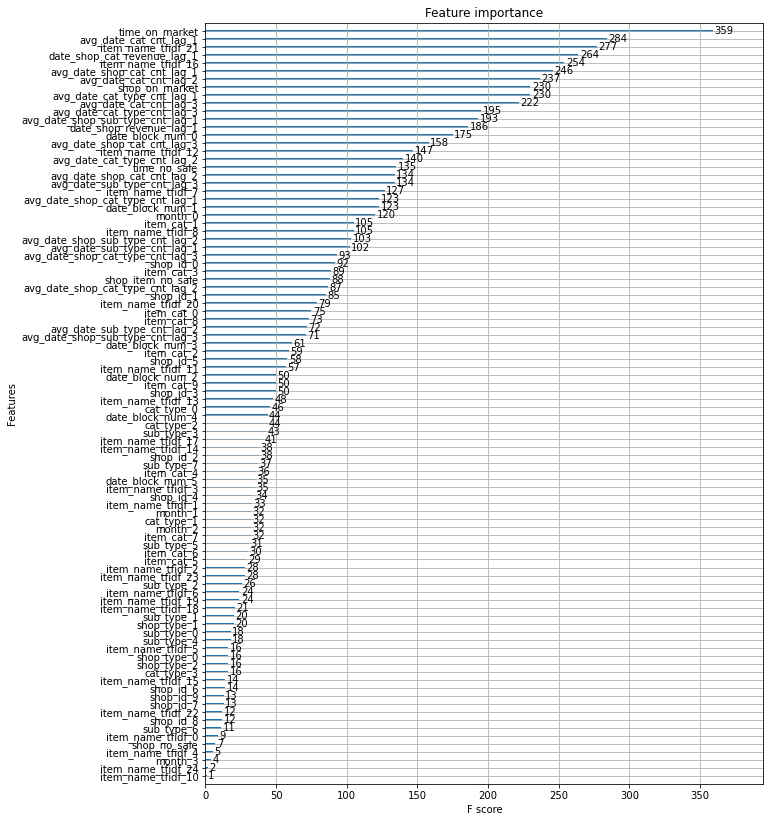

In [27]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(xgb_first_sale, (10,14))

#### 6.2.2 High Loss Shops

In [28]:
X_train_first_sale_hl = first_sale_data[(first_sale_data.date_block_num <= train_date_block)  & \
                               first_sale_data.shop_id.isin(high_loss_shops)].drop(['date_shop_item_cnt'], axis=1)
Y_train_first_sale_hl = first_sale_data[(first_sale_data.date_block_num <= train_date_block)  & \
                               first_sale_data.shop_id.isin(high_loss_shops)]['date_shop_item_cnt']
X_valid_first_sale_hl = first_sale_data[(first_sale_data.date_block_num == val_date_block) & \
                               (first_sale_data.time_on_market == 0) & \
                               first_sale_data.shop_id.isin(high_loss_shops)].drop(['date_shop_item_cnt'], axis=1)
Y_valid_first_sale_hl = first_sale_data[(first_sale_data.date_block_num == val_date_block) & \
                               (first_sale_data.time_on_market == 0)  & \
                               first_sale_data.shop_id.isin(high_loss_shops)]['date_shop_item_cnt']

In [29]:
X_train_first_sale_hl_ft = X_train_first_sale_hl.drop(['item_id'], axis=1)
Y_train_first_sale_hl_ft = Y_train_first_sale_hl.copy()
X_valid_first_sale_hl_ft = X_valid_first_sale_hl.drop(['item_id'], axis=1)
Y_valid_first_sale_hl_ft = Y_valid_first_sale_hl.copy()

In [30]:
embed_drop_list = [
    'date_block_num',
    'shop_id',
    'shop_type',
    'item_category_id', 
    'cat_type',
    'sub_type',
    'month',
]

X_train_first_sale_hl_ft.drop(embed_drop_list, axis=1, inplace=True)
X_valid_first_sale_hl_ft.drop(embed_drop_list, axis=1, inplace=True)

In [31]:
from xgboost import XGBRegressor
from xgboost import plot_importance


xgb_first_sale_hl = XGBRegressor(
    max_depth=10,
    n_estimators=250,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.2, 
    reg_alpha=0.17,
    reg_lambda=0.171,
    seed=42)

xgb_first_sale_hl.fit(
    X_train_first_sale_hl_ft, 
    Y_train_first_sale_hl_ft, 
    eval_metric="rmse", 
    eval_set=[(X_train_first_sale_hl_ft, Y_train_first_sale_hl_ft), (X_valid_first_sale_hl_ft, Y_valid_first_sale_hl_ft)], 
    verbose=True, 
    early_stopping_rounds = 10)


[0]	validation_0-rmse:3.06546	validation_1-rmse:3.05046
[1]	validation_0-rmse:2.95147	validation_1-rmse:2.96661
[2]	validation_0-rmse:2.87032	validation_1-rmse:2.91825
[3]	validation_0-rmse:2.81667	validation_1-rmse:2.86780
[4]	validation_0-rmse:2.77939	validation_1-rmse:2.82842
[5]	validation_0-rmse:2.75093	validation_1-rmse:2.80445
[6]	validation_0-rmse:2.72958	validation_1-rmse:2.78431
[7]	validation_0-rmse:2.71267	validation_1-rmse:2.76246
[8]	validation_0-rmse:2.69954	validation_1-rmse:2.74612
[9]	validation_0-rmse:2.68958	validation_1-rmse:2.72610
[10]	validation_0-rmse:2.67843	validation_1-rmse:2.70092
[11]	validation_0-rmse:2.67346	validation_1-rmse:2.69877
[12]	validation_0-rmse:2.66910	validation_1-rmse:2.69694
[13]	validation_0-rmse:2.66294	validation_1-rmse:2.68783
[14]	validation_0-rmse:2.65861	validation_1-rmse:2.68350
[15]	validation_0-rmse:2.65598	validation_1-rmse:2.68025
[16]	validation_0-rmse:2.65192	validation_1-rmse:2.67795
[17]	validation_0-rmse:2.65016	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=10,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.17, reg_lambda=0.171, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

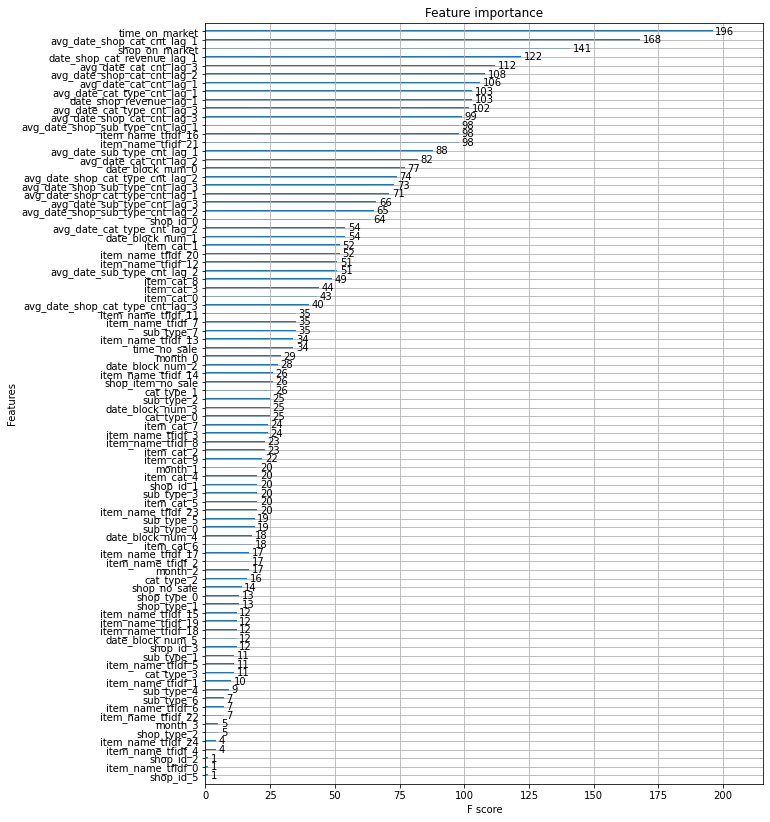

In [32]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(xgb_first_sale_hl, (10,14))

#### 6.3 Validation

In [33]:
#Y_pred_on_sale_lgb = lgb_on_sale.predict(X_valid_on_sale_ft).clip(0,20)
#Y_pred_on_sale_xgb = xgb_on_sale.predict(X_valid_on_sale_ft).clip(0,20)
#Y_pred_on_sale = 0.67*Y_pred_on_sale_lgb + 0.33*Y_pred_on_sale_xgb
#Y_pred_on_sale = ridge_on_sale.predict(X_valid_on_sale_ft).clip(0,20)[:,2]

Y_pred_on_sale = xgb_on_sale.predict(X_valid_on_sale_ft).clip(0,20)

X_valid_on_sale = X_valid_on_sale[['shop_id', 'item_id']]
X_valid_on_sale['Y_pred_on_sale'] = Y_pred_on_sale
X_valid_on_sale

,shop_id,item_id,Y_pred_on_sale
10674594,2,30,0.015201
10674595,2,31,0.060033
10674596,2,32,0.169429
10674597,2,33,0.248371
10674598,2,40,0.000000
...,...,...,...
10912761,59,22162,0.092632
10912762,59,22163,0.139262
10912763,59,22164,0.156798
10912764,59,22166,0.002915


In [35]:
Y_pred_on_sale_hl = xgb_on_sale_hl.predict(X_valid_on_sale_hl_ft).clip(0,20)
X_valid_on_sale_hl = X_valid_on_sale_hl[['shop_id', 'item_id']]
X_valid_on_sale_hl['Y_pred_on_sale_hl'] = Y_pred_on_sale_hl
X_valid_on_sale_hl

,shop_id,item_id,Y_pred_on_sale_hl
10707072,9,30,0.122712
10707073,9,31,0.000000
10707074,9,32,0.133880
10707075,9,33,0.000000
10707076,9,40,0.000000
...,...,...,...
10891109,55,22162,0.004498
10891110,55,22163,0.004882
10891111,55,22164,0.007479
10891112,55,22166,6.758199


In [36]:
#Y_pred_first_sale_lgb = lgb_first_sale.predict(X_valid_first_sale_ft).clip(0,20)
#Y_pred_first_sale_xgb = xgb_first_sale.predict(X_valid_first_sale_ft).clip(0,20)
#Y_pred_first_sale = 0.67 * Y_pred_first_sale_lgb + 0.33 * Y_pred_first_sale_xgb

Y_pred_first_sale = xgb_first_sale.predict(X_valid_first_sale_ft).clip(0,20)

X_valid_first_sale = X_valid_first_sale[['shop_id', 'item_id']]
X_valid_first_sale['Y_pred_first_sale'] = Y_pred_first_sale
X_valid_first_sale

,shop_id,item_id,Y_pred_first_sale
10674617,2,138,0.017289
10674618,2,139,0.017289
10674619,2,146,0.007760
10674620,2,147,0.007760
10674626,2,159,0.007760
...,...,...,...
10912723,59,21973,0.075954
10912731,59,22004,0.441092
10912732,59,22005,0.441092
10912733,59,22006,0.441092


In [37]:
Y_pred_first_sale_hl = xgb_first_sale_hl.predict(X_valid_first_sale_hl_ft).clip(0,20)

X_valid_first_sale_hl = X_valid_first_sale_hl[['shop_id', 'item_id']]
X_valid_first_sale_hl['Y_pred_first_sale_hl'] = Y_pred_first_sale_hl
X_valid_first_sale_hl

,shop_id,item_id,Y_pred_first_sale_hl
10707095,9,138,0.000000
10707096,9,139,0.000000
10707097,9,146,0.000000
10707098,9,147,0.000000
10707104,9,159,0.000000
...,...,...,...
10891071,55,21973,0.032365
10891079,55,22004,0.044114
10891080,55,22005,0.044114
10891081,55,22006,0.044114


In [38]:
Y_valid = data[data.date_block_num == val_date_block]

'''
shop_list = list(data[data.date_block_num == test_date_block].shop_id.unique())
item_list = list(data[data.date_block_num == test_date_block].item_id.unique())
Y_valid = Y_valid[Y_valid.shop_id.isin(shop_list)]
Y_valid = Y_valid[Y_valid.item_id.isin(item_list)]
'''
Y_valid

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,sub_type_2,sub_type_3,sub_type_4,sub_type_5,sub_type_6,sub_type_7,month_0,month_1,month_2,month_3
10674594,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,1.603588,-0.706945,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556
10674595,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,2.277320,-0.846083,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556
10674596,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,1.603588,-0.706945,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556
10674597,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,2.277320,-0.846083,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556
10674598,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,1.099456,-0.543302,-0.616452,0.565170,-0.831102,1.257596,0.132109,-0.063321,0.136406,0.305556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10912761,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,1.603588,-0.706945,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556
10912762,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,1.603588,-0.706945,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556
10912763,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,2.277320,-0.846083,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556
10912764,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,0.681390,-0.769049,-0.814706,0.774649,-0.614455,0.033577,0.132109,-0.063321,0.136406,0.305556


In [39]:
Y_valid = pd.merge(Y_valid, X_valid_on_sale, on=['shop_id', 'item_id'], how='left')
Y_valid = pd.merge(Y_valid, X_valid_on_sale_hl, on=['shop_id', 'item_id'], how='left')
Y_valid

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,sub_type_4,sub_type_5,sub_type_6,sub_type_7,month_0,month_1,month_2,month_3,Y_pred_on_sale,Y_pred_on_sale_hl
0,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.015201,NaN
1,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.060033,NaN
2,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.169429,NaN
3,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.248371,NaN
4,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,-0.616452,0.565170,-0.831102,1.257596,0.132109,-0.063321,0.136406,0.305556,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238167,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.092632,NaN
238168,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.139262,NaN
238169,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.156798,NaN
238170,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,-0.814706,0.774649,-0.614455,0.033577,0.132109,-0.063321,0.136406,0.305556,0.002915,NaN


In [40]:
Y_valid = pd.merge(Y_valid, X_valid_first_sale, on=['shop_id', 'item_id'], how='left')
Y_valid = pd.merge(Y_valid, X_valid_first_sale_hl, on=['shop_id', 'item_id'], how='left')
Y_valid

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,sub_type_6,sub_type_7,month_0,month_1,month_2,month_3,Y_pred_on_sale,Y_pred_on_sale_hl,Y_pred_first_sale,Y_pred_first_sale_hl
0,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.015201,NaN,NaN,NaN
1,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.060033,NaN,NaN,NaN
2,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.169429,NaN,NaN,NaN
3,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.248371,NaN,NaN,NaN
4,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,-0.831102,1.257596,0.132109,-0.063321,0.136406,0.305556,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238167,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.092632,NaN,NaN,NaN
238168,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.139262,NaN,NaN,NaN
238169,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.156798,NaN,NaN,NaN
238170,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,-0.614455,0.033577,0.132109,-0.063321,0.136406,0.305556,0.002915,NaN,NaN,NaN


In [41]:
def merge_prediction(row):
    if pd.isnull(row.Y_pred_first_sale):
        if pd.isnull(row.Y_pred_on_sale_hl):
            return row.Y_pred_on_sale
        else:
            return row.Y_pred_on_sale_hl
    else:
        if pd.isnull(row.Y_pred_first_sale_hl):
            return row.Y_pred_first_sale
        else:
            return row.Y_pred_first_sale_hl

Y_valid['Y_pred'] = Y_valid.swifter.apply(merge_prediction, axis=1).fillna(0).astype(np.float16)

del Y_valid['Y_pred_first_sale']
del Y_valid['Y_pred_on_sale']
del Y_valid['Y_pred_first_sale_hl']
del Y_valid['Y_pred_on_sale_hl']

Y_valid

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,sub_type_3,sub_type_4,sub_type_5,sub_type_6,sub_type_7,month_0,month_1,month_2,month_3,Y_pred
0,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,-0.706945,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.015198
1,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,-0.846083,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.060028
2,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,-0.706945,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.169434
3,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,-0.846083,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.248413
4,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,-0.543302,-0.616452,0.565170,-0.831102,1.257596,0.132109,-0.063321,0.136406,0.305556,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238167,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,-0.706945,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.092651
238168,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,-0.706945,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.139282
238169,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,-0.846083,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.156738
238170,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,-0.769049,-0.814706,0.774649,-0.614455,0.033577,0.132109,-0.063321,0.136406,0.305556,0.002914


In [42]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(Y_valid['date_shop_item_cnt'], Y_valid['Y_pred']))

print("The final rmse is {}".format(rmse))

The final rmse is 0.8544921875


#### 6.5 Error Analysis

#### 6.5.1 RMSE Calculation

In [43]:
df_item_id_rmse = Y_valid[['item_id', 'date_shop_item_cnt', 'Y_pred']].reset_index(drop=True)
item_id_rmse = [-1] * (Y_valid.item_id.max() + 1)

for index, row in df_item_id_rmse.iterrows():
    if item_id_rmse[int(row.item_id)] == -1:
        item_id_rmse[int(row.item_id)] = np.sqrt(mean_squared_error(
            df_item_id_rmse[df_item_id_rmse.item_id == row.item_id]['date_shop_item_cnt'], 
            df_item_id_rmse[df_item_id_rmse.item_id == row.item_id]['Y_pred']
        ))

def apply_item_id_rmse(row):
    return item_id_rmse[int(row.item_id)]

Y_valid['item_id_rmse'] = Y_valid.swifter.apply(apply_item_id_rmse, axis=1).astype(np.float16) 
Y_valid

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,sub_type_4,sub_type_5,sub_type_6,sub_type_7,month_0,month_1,month_2,month_3,Y_pred,item_id_rmse
0,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.015198,0.144531
1,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.060028,0.659180
2,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.169434,0.638672
3,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.248413,0.491943
4,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,-0.616452,0.565170,-0.831102,1.257596,0.132109,-0.063321,0.136406,0.305556,0.000000,0.094543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238167,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.092651,0.476807
238168,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,-0.903334,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.139282,0.708984
238169,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,-1.019895,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.156738,0.665039
238170,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,-0.814706,0.774649,-0.614455,0.033577,0.132109,-0.063321,0.136406,0.305556,0.002914,0.648438


In [44]:
df_shop_id_rmse = Y_valid[['shop_id', 'date_shop_item_cnt', 'Y_pred']].reset_index(drop=True)
shop_id_rmse = [-1] * (Y_valid.shop_id.max() + 1)

for index, row in df_shop_id_rmse.iterrows():
    if shop_id_rmse[int(row.shop_id)] == -1:
        shop_id_rmse[int(row.shop_id)] = np.sqrt(mean_squared_error(
            df_shop_id_rmse[df_shop_id_rmse.shop_id == row.shop_id]['date_shop_item_cnt'], 
            df_shop_id_rmse[df_shop_id_rmse.shop_id == row.shop_id]['Y_pred']
        ))

def apply_shop_id_rmse(row):
    return shop_id_rmse[int(row.shop_id)]

Y_valid['shop_id_rmse'] = Y_valid.swifter.apply(apply_shop_id_rmse, axis=1).astype(np.float16) 
Y_valid

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,sub_type_5,sub_type_6,sub_type_7,month_0,month_1,month_2,month_3,Y_pred,item_id_rmse,shop_id_rmse
0,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.015198,0.144531,0.559082
1,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.060028,0.659180,0.559082
2,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.169434,0.638672,0.559082
3,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.248413,0.491943,0.559082
4,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,0.565170,-0.831102,1.257596,0.132109,-0.063321,0.136406,0.305556,0.000000,0.094543,0.559082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238167,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.092651,0.476807,0.487549
238168,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,0.712955,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.139282,0.708984,0.487549
238169,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,0.715887,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.156738,0.665039,0.487549
238170,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,0.774649,-0.614455,0.033577,0.132109,-0.063321,0.136406,0.305556,0.002914,0.648438,0.487549


In [45]:
df_cat_id_rmse = Y_valid[['item_category_id', 'date_shop_item_cnt', 'Y_pred']].reset_index(drop=True)
cat_id_rmse = [-1] * (Y_valid.item_category_id.max() + 1)

for index, row in df_cat_id_rmse.iterrows():
    if cat_id_rmse[int(row.item_category_id)] == -1:
        cat_id_rmse[int(row.item_category_id)] = np.sqrt(mean_squared_error(
            df_cat_id_rmse[df_cat_id_rmse.item_category_id == row.item_category_id]['date_shop_item_cnt'], 
            df_cat_id_rmse[df_cat_id_rmse.item_category_id == row.item_category_id]['Y_pred']
        ))

def apply_cat_id_rmse(row):
    return cat_id_rmse[int(row.item_category_id)]

Y_valid['cat_id_rmse'] = Y_valid.swifter.apply(apply_cat_id_rmse, axis=1).astype(np.float16) 
Y_valid

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,sub_type_6,sub_type_7,month_0,month_1,month_2,month_3,Y_pred,item_id_rmse,shop_id_rmse,cat_id_rmse
0,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.015198,0.144531,0.559082,0.639648
1,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.060028,0.659180,0.559082,0.708496
2,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.169434,0.638672,0.559082,0.639648
3,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.248413,0.491943,0.559082,0.708496
4,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,-0.831102,1.257596,0.132109,-0.063321,0.136406,0.305556,0.000000,0.094543,0.559082,0.260986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238167,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.092651,0.476807,0.487549,0.639648
238168,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,-1.091941,1.659046,0.132109,-0.063321,0.136406,0.305556,0.139282,0.708984,0.487549,0.639648
238169,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,-1.351326,2.533916,0.132109,-0.063321,0.136406,0.305556,0.156738,0.665039,0.487549,0.708496
238170,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,-0.614455,0.033577,0.132109,-0.063321,0.136406,0.305556,0.002914,0.648438,0.487549,0.465820


In [46]:
Y_valid.to_csv('rmse_28_xgb_nr_m2_hl.csv', index=False)

In [47]:
shop_id_rmse_rank = Y_valid[['shop_id', 'shop_id_rmse']].sort_values(by='shop_id_rmse', ascending=False).drop_duplicates()
shop_id_rmse_rank.head(10)

,shop_id,shop_id_rmse
75783,20,2.007812
34284,9,2.001953
101040,25,1.650391
113674,31,1.543945
156978,42,1.452148
108262,28,1.087891
212909,55,0.944336
86607,21,0.828125
24357,6,0.825195
184039,47,0.818848


In [48]:
item_id_rmse_rank = Y_valid[['item_id', 'item_id_rmse']].sort_values(by='item_id_rmse', ascending=False).drop_duplicates()
item_id_rmse_rank.head(20)

,item_id,item_id_rmse
191207,7223,10.531250
13219,10202,9.914062
2392,10201,9.289062
130284,1583,8.171875
95143,13247,7.085938
39644,7224,6.781250
225575,15069,5.664062
176333,13241,5.628906
134248,17775,5.503906
76323,2423,5.457031


In [49]:
cat_id_rmse_rank = Y_valid[['item_category_id', 'cat_id_rmse']].sort_values(by='cat_id_rmse', ascending=False).drop_duplicates()
cat_id_rmse_rank.head(20)

,item_category_id,cat_id_rmse
107937,71,3.798828
96343,79,3.646484
92006,42,3.406250
115115,35,2.554688
158479,20,2.458984
151544,83,2.205078
70685,28,1.783203
90248,29,1.700195
143834,47,1.684570
12730,33,1.616211


#### 6.6 Model Test

In [50]:
X_test_on_sale = on_sale_data[(on_sale_data.date_block_num == 34) & \
                              (on_sale_data.time_on_market > 0) &\
                               on_sale_data.shop_id.isin(normal_shops)]\
                             .drop(['date_shop_item_cnt'], axis=1)
X_test_on_sale_hl = on_sale_data[(on_sale_data.date_block_num == 34) & \
                              (on_sale_data.time_on_market > 0) &\
                               on_sale_data.shop_id.isin(high_loss_shops)]\
                             .drop(['date_shop_item_cnt'], axis=1)
X_test_on_sale_ft = X_test_on_sale.copy()
X_test_on_sale_ft.drop(embed_drop_list, axis=1, inplace=True)
X_test_on_sale_hl_ft = X_test_on_sale_hl.copy()
X_test_on_sale_hl_ft.drop(embed_drop_list, axis=1, inplace=True)


#X_test_on_sale_hl.drop(drop_list_first_sale_hl, axis=1, inplace=True)

#Y_test_on_sale_lgb = lgb_on_sale.predict(X_test_on_sale).clip(0,20)
#Y_test_on_sale_xgb = xgb_on_sale.predict(X_test_on_sale).clip(0,20)
#Y_test_on_sale = 0.67*Y_test_on_sale_lgb + 0.33*Y_test_on_sale_xgb
Y_test_on_sale = xgb_on_sale.predict(X_test_on_sale_ft).clip(0,20)
Y_test_on_sale_hl = xgb_on_sale_hl.predict(X_test_on_sale_hl_ft).clip(0,20)

X_test_on_sale = X_test_on_sale[['shop_id', 'item_id']]
X_test_on_sale['Y_test_on_sale'] = Y_test_on_sale
X_test_on_sale_hl['Y_test_on_sale_hl'] = Y_test_on_sale_hl

In [51]:
X_test_first_sale = first_sale_data[(first_sale_data.date_block_num == 34) & \
                                    (first_sale_data.time_on_market == 0) & \
                                    first_sale_data.shop_id.isin(normal_shops)] \
                                    .drop(['date_shop_item_cnt'], axis=1)
X_test_first_sale_ft = X_test_first_sale.copy()
X_test_first_sale_ft = X_test_first_sale_ft.drop(['item_id'], axis=1)
X_test_first_sale_ft.drop(embed_drop_list, axis=1, inplace=True)


X_test_first_sale_hl = first_sale_data[(first_sale_data.date_block_num == 34) & \
                                    (first_sale_data.time_on_market == 0) & \
                                    first_sale_data.shop_id.isin(high_loss_shops)] \
                                    .drop(['date_shop_item_cnt'], axis=1)
X_test_first_sale_hl_ft = X_test_first_sale_hl.copy()
#X_test_first_sale_hl_ft.drop(drop_list_first_sale_hl, axis=1, inplace=True)
X_test_first_sale_hl_ft = X_test_first_sale_hl_ft.drop(['item_id'], axis=1)
X_test_first_sale_hl_ft.drop(embed_drop_list, axis=1, inplace=True)

#Y_test_first_sale_lgb = lgb_first_sale.predict(X_test_first_sale_ft).clip(0,20)
#Y_test_first_sale_xgb = xgb_first_sale.predict(X_test_first_sale_ft).clip(0,20)
#Y_test_first_sale = 0.67*Y_test_first_sale_lgb + 0.33*Y_test_first_sale_xgb
Y_test_first_sale = xgb_first_sale.predict(X_test_first_sale_ft).clip(0,20)
Y_test_first_sale_hl = xgb_first_sale_hl.predict(X_test_first_sale_hl_ft).clip(0,20)

X_test_first_sale = X_test_first_sale[['shop_id', 'item_id']]
X_test_first_sale['Y_test_first_sale'] = Y_test_first_sale
X_test_first_sale_hl['Y_test_first_sale_hl'] = Y_test_first_sale_hl

In [52]:
X_test = data[data.date_block_num == 34].drop(['date_shop_item_cnt'], axis=1)
Y_test = X_test[['shop_id', 'item_id']]

Y_test = pd.merge(Y_test, X_test_on_sale, on=['shop_id', 'item_id'], how='left')
Y_test = pd.merge(Y_test, X_test_on_sale_hl, on=['shop_id', 'item_id'], how='left')
Y_test = pd.merge(Y_test, X_test_first_sale, on=['shop_id', 'item_id'], how='left')
Y_test = pd.merge(Y_test, X_test_first_sale_hl, on=['shop_id', 'item_id'], how='left')
Y_test

,shop_id,item_id,Y_test_on_sale,date_block_num_x,shop_type_x,item_category_id_x,item_name_tfidf_0_x,item_name_tfidf_1_x,item_name_tfidf_2_x,item_name_tfidf_3_x,...,sub_type_3_y,sub_type_4_y,sub_type_5_y,sub_type_6_y,sub_type_7_y,month_0_y,month_1_y,month_2_y,month_3_y,Y_test_first_sale_hl
0,5,5037,0.740714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,5233,1.108110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,5232,0.526754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,0.068705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214196,45,16188,0.015953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,45,15757,0.040241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214198,45,19648,0.010586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
def merge_test(row):
    if pd.isnull(row.Y_test_first_sale):
        if pd.isnull(row.Y_test_on_sale_hl):
            return row.Y_test_on_sale
        else:
            return row.Y_test_on_sale_hl
    else:
        if pd.isnull(row.Y_test_first_sale_hl):
            return row.Y_test_first_sale
        else:
            return row.Y_test_first_sale_hl
'''
def merge_test(row):
    if pd.isnull(row.Y_test_first_sale):
        return row.Y_test_on_sale
    else:
        return row.Y_test_first_sale
'''

Y_test['result'] = Y_test.swifter.apply(merge_test, axis=1).fillna(0).astype(np.float16)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [54]:
# load test data set
df_test = pd.read_csv("v30_test_clean.csv")

submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test.result.values
})

submission.to_csv('v30_submission_xgb_nr_m2_hl.csv', index=False)

In [55]:
print("complete!")

complete!


#### 6.7 Model Saving

In [56]:
import pickle

pickle.dump(xgb_on_sale, open("v30_xgb_on_sale.pkl", "wb"))
pickle.dump(xgb_on_sale_hl, open("v30_xgb_on_sale_hl.pkl", "wb"))
pickle.dump(xgb_first_sale, open("v30_xgb_first_sale.pkl", "wb"))
pickle.dump(xgb_first_sale_hl, open("v30_xgb_first_sale_hl.pkl", "wb"))

In [57]:
print("xgb model saved!")

xgb model saved!


In [58]:
#0.90446

In [59]:
del data
del on_sale_data
del first_sale_data

gc.collect()

256